# Extracting Features

In [1]:
import numpy as np
import networkx as nx
# Load the adjacency matrix into a numpy array.
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
for i in range(0,70):
        normal_mat[i][i] = 0
G_Normal = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G_Normal.edges()))
print("Number Of Nodes: ",len(G_Normal.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [2]:
# Load the adjacency matrix into a numpy array.
eMCI_mat = np.loadtxt('../eMCI.txt', dtype=int)
for i in range(0,70):
        eMCI_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(eMCI_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1510
Number Of Nodes:  70


# Edge to Vector

In [3]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


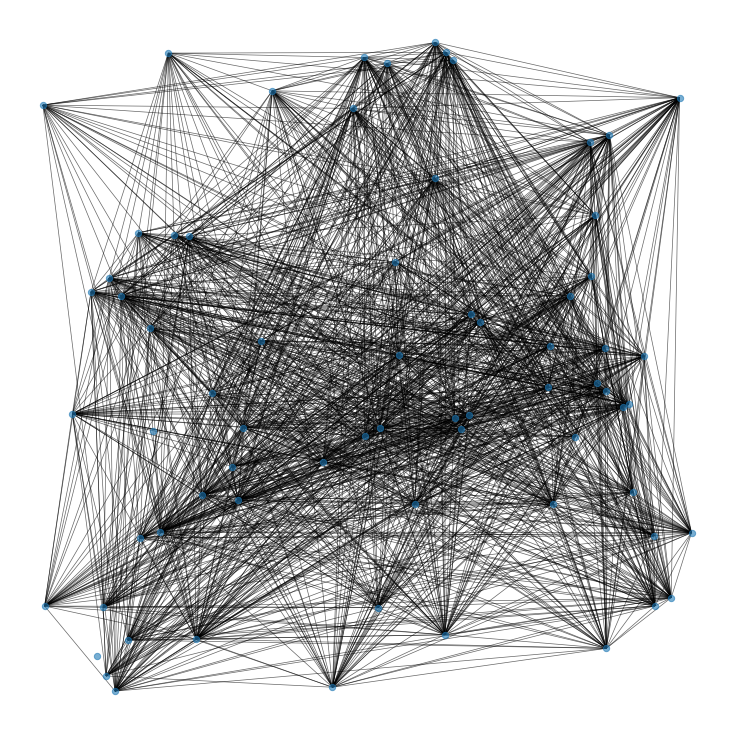

In [4]:
plt.figure(figsize=(10,10))
pos = nx.random_layout(G_eMCI, seed=23)
nx.draw(G_eMCI, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

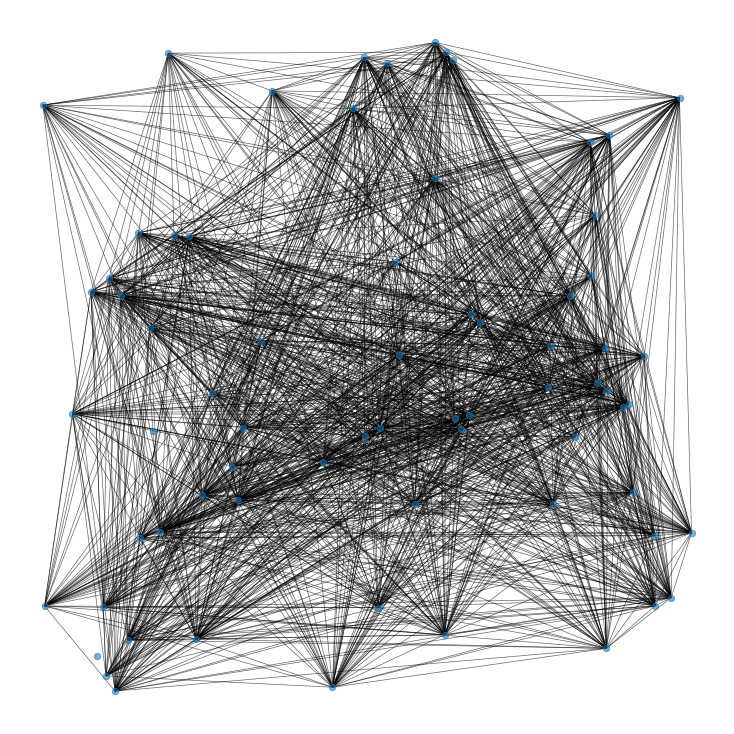

In [5]:
plt.figure(figsize=(10,10))
pos = nx.random_layout(G_Normal, seed=23)
nx.draw(G_Normal, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

In [6]:
edges = list(G_Normal.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

In [7]:
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [8]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

In [9]:
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)

In [10]:
adj_G.shape

(68, 68)

In [11]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if adj_G[i,j] == 0:
        all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 68/68 [00:00<00:00, 4343.52it/s]


In [12]:
len(all_unconnected_pairs)

788

In [13]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [14]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 1490/1490 [00:08<00:00, 175.66it/s]


In [15]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)


In [16]:
data['link'].value_counts()

1    1423
0     788
Name: link, dtype: int64

In [17]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())


In [18]:
#from node2vec import Node2Vec

# Generate walks
#node2vc = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
#n2w_model = node2vc.fit(window=7, min_count=1)

In [19]:
!pip install node2vec 

In [20]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


In [21]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [28]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

C:\Users\Divay Mohan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
predictions = lr.predict_proba(xtest)

In [30]:
roc_auc_score(ytest, predictions[:,1])

0.6121389539422326

In [ ]:
'''import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)
'''

# Feature Vector With Edges

In [32]:
fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [36]:
import networkx as nx 
edges = list(G_Normal.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))
print(node_list)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


In [29]:
df_AllNodes = pd.DataFrame()
AA = []
PA = []
RAI = []
JC = []
CSH = []
RAISH = []
WIC = []
_node1 = []
_node2 = []


In [30]:
for i in node_list:
    for j in node_list:
        if i != j:
            _node1.append(i)
            _node2.append(j)
            AA.append(list(nx.adamic_adar_index(G,ebunch=[(i,j)]))[0][2])
            RAI.append(list(nx.resource_allocation_index(G,ebunch=[(i,j)]))[0][2])
            PA.append(list(nx.preferential_attachment(G,ebunch=[(i,j)]))[0][2])
            JC.append(list(nx.jaccard_coefficient(G,ebunch=[(i,j)]))[0][2])

In [31]:
df_AllNodes['node1'] = _node1
df_AllNodes['node2'] = _node2     
df_AllNodes['AA'] = AA     
df_AllNodes['RAI'] = RAI
df_AllNodes['PA'] = PA
df_AllNodes['JC'] = JC     

In [32]:
df_AllNodes.head(5)

,node1,node2,AA,RAI,PA,JC
0,0,1,8.629530,0.725473,1813,0.622642
1,0,2,8.919526,0.757370,1850,0.641509
2,0,4,6.969278,0.563268,1295,0.600000
3,0,5,7.374409,0.633878,1147,0.700000
4,0,6,9.472994,0.812668,1702,0.765957
